In [ ]:
! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
# python -m spacy download pt_core_news_sm

In [2]:
from datasets import load_dataset

dataset = load_dataset("higopires/RePro-categories-multilabel")

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Verificar as chaves disponíveis
print(dataset.keys())

# Visualizar alguns exemplos
print(dataset["train"][2]) 

dict_keys(['train', 'validation', 'test'])
{'review_text': 'Entrega rápida, produto muito bom Amei. Praticidade', 'ENTREGA': 1, 'OUTROS': 0, 'PRODUTO': 1, 'CONDICOESDERECEBIMENTO': 0, 'INADEQUADA': 0, 'ANUNCIO': 0}


In [4]:
# Ver número de exemplos em cada divisão do dataset
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
import pandas as pd
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


### Pre-processing steps

In [7]:
# Obter as colunas (nomes dos labels)
columns = list(dataset["train"].features.keys())
labels = columns[1:]  # Excluindo 'review_text'

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


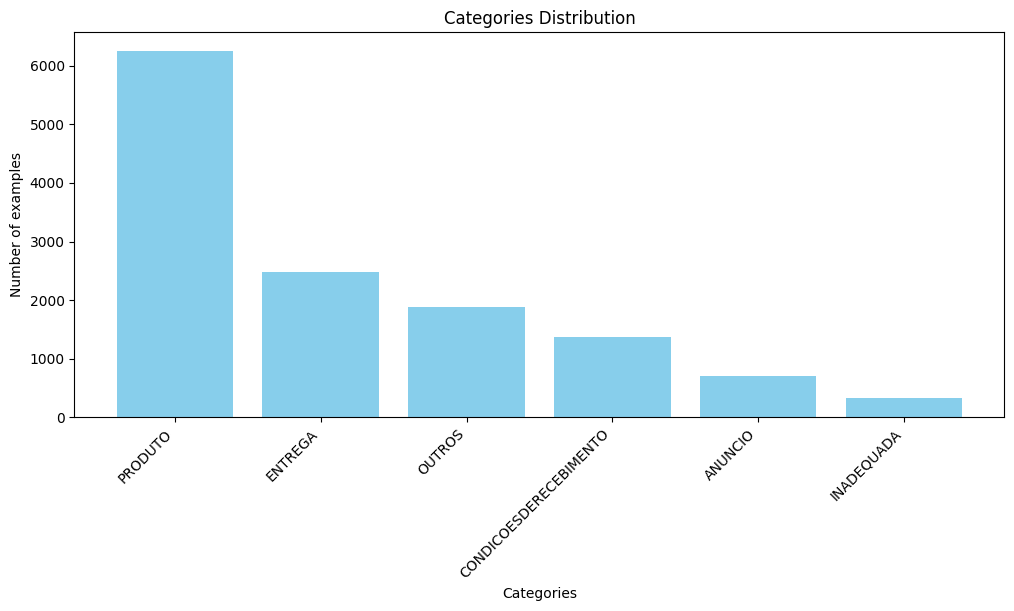

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar a ocorrência de cada label
label_counts = {label: 0 for label in labels}

for example in dataset["train"]:
    for label in labels:
        label_counts[label] += example[label]  # Somamos os 1s para cada label

# Ordenar por frequência
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

# Plotar gráfico
plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

In [9]:
import numpy as np

text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")  
print(f"Maximum text length: {np.max(text_lengths)} words")  
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


In [10]:
import spacy
import re

# Load the Portuguese language model
nlp = spacy.load('pt_core_news_sm')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and lemmatize using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply preprocessing to the reviews
train_data['cleaned_reviews'] = train_data['review_text'].apply(preprocess_text)
val_data['cleaned_reviews'] = val_data['review_text'].apply(preprocess_text)
test_data['cleaned_reviews'] = test_data['review_text'].apply(preprocess_text)

In [11]:
print("Original text:")
print(train_data['review_text'][0])
print("\nPreprocessed text:")
print(train_data['cleaned_reviews'][0])

Original text:
Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!

Preprocessed text:
aparelho confiável aquisitivo conta ser massa precisar


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your dataset size

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_reviews'])

# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['cleaned_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word 
print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 words by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Training data shape: (8002, 5000)
Validation data shape: (994, 5000)
Test data shape: (1007, 5000)

Top 20 words by TF-IDF score:
produto: 508.4886
chegar: 211.3920
prazo: 200.0730
qualidade: 192.8037
gostar: 190.1644
entrega: 186.2115
entregar: 181.2259
bom: 164.3852
excelente: 155.8344
rápido: 155.3172
recomendar: 151.3572
dia: 150.4774
vir: 140.2272
recebi: 133.1618
recomendo: 132.8761
super: 122.7989
comprei: 121.2868
atender: 113.6366
compra: 113.1990
comprar: 106.9568
